In [15]:
# =============== Imports & Hyperparameters ===============
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from copy import deepcopy
import itertools



In [36]:
# ====================== Training Configuration ======================

DATASET_NAME = "pathmnist"      # Dataset used for the project
BATCH_SIZE    = 256             # Larger batch for stable training on 64x64 images

# ----- Image Normalization (Used in All Models) -----
# Standard ImageNet normalization required for pretrained models
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# ----- FNN (Alternative Model 1) -----
# FNN requires hyperparameter tuning AND final training
FNN_TUNE_EPOCHS  = 5            # short proxy training for hyperparameter search
FNN_FINAL_EPOCHS = 10           # full training after choosing best hyperparameters
FNN_LR_OPTIONS   = [1e-3, 3e-4] # learning rates tried during tuning
FNN_HIDDEN_OPTIONS = [
    [256, 256],
    [512, 256],
]
FNN_DROPOUT_OPTIONS = [0.3, 0.5]

# ----- SimpleCNN (Primary Baseline Model) -----
# CNN does NOT require hyperparameter tuning
EPOCHS_CNN = 8                  # enough for baseline CNN to converge
LR_CNN = 1e-3                   # standard Adam LR for mid-size CNNs

# ----- Pretrained ResNet18 (Improved Model) -----
# Transfer learning: small LR and slightly more epochs
EPOCHS_RESNET = 12
LR_RESNET = 1e-4                # fine-tuning requires a smaller LR
USE_PRETRAINED_RESNET = True    # use ImageNet weights


# PathMNIST class names in index order 0..8
PATHMNIST_CLASS_NAMES = [
    "adipose tissue",                       # 0
    "background",                           # 1
    "debris",                               # 2
    "lymphocytes",                          # 3
    "mucus",                                # 4
    "smooth muscle",                        # 5
    "normal colon mucosa",                  # 6
    "cancer-associated stroma",             # 7
    "colorectal adenocarcinoma epithelium"  # 8
]




In [29]:
# ====================== Utils ======================

def get_device():
    """Return GPU device if available, otherwise CPU."""
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", DEVICE)
    return DEVICE

def set_seed(seed=42):
    """Set random seed for reproducibility."""
    import random
    random.seed(seed)
    np.random.seed(seed) 
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def denormalize_image(img_tensor):
    """
    Undo ImageNet normalization for visualization.
    img_tensor: tensor [3,H,W], normalized by IMAGENET_MEAN/STD.
    Returns a tensor in [0,1].
    """
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1).to(img_tensor.device)
    img = img_tensor * std + mean
    img = torch.clamp(img, 0.0, 1.0)
    return img

def plot_accuracy(train_acc, val_acc, title="Train vs Val Accuracy"):
    plt.figure(figsize=(7,5))
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()


def plot_loss(train_loss, val_loss, title="Train vs Val Loss"):
    plt.figure(figsize=(7,5))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

def plot_history(history, title="Model", save_path=None):
    import matplotlib.pyplot as plt
    import numpy as np
    
    epochs = range(1, len(history["train_acc"]) + 1)
    train = history["train_acc"]
    val   = history["val_acc"]

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train, label="Train Acc", linewidth=2)
    plt.plot(epochs, val,   label="Val Acc", linewidth=2)

    # --- PROFESSIONAL Y-AXIS IMPROVEMENT ---
    ymin = min(train + val)
    ymax = max(train + val)
    margin = 0.01  # small padding above/below curves

    plt.ylim(ymin - margin, ymax + margin)  
    plt.yticks(np.arange(round(ymin,3), round(ymax+0.005,3), 0.01))
    # ---------------------------------------

    plt.xticks(list(epochs))  # 1,2,3,...

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title}: Train vs Validation Accuracy")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()



In [4]:
# ====================== Data ======================

def get_medmnist_dataloaders(dataset_name=DATASET_NAME, batch_size=BATCH_SIZE):
    """
    Load MedMNIST dataset (train/val/test) with preprocessing.

    Preprocessing:
      - resize to 64x64 (slightly larger than original 28x28)
      - convert to tensor in [0,1]
      - convert 1-channel images to 3-channel
      - apply ImageNet normalization

    Train loader uses data augmentation:
      - random horizontal flip
      - small random rotation
    """
    info = INFO[dataset_name]
    DataClass = getattr(medmnist, info["python_class"])
    num_classes = len(info["label"])

    # Data augmentation for training
    transform_train = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    # Evaluation transform (no augmentation)
    transform_eval = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    train_dataset = DataClass(split="train", transform=transform_train, download=True)
    val_dataset = DataClass(split="val", transform=transform_eval, download=True)
    test_dataset = DataClass(split="test", transform=transform_eval, download=True)

    # num_workers=0 to avoid multiprocessing issues in Jupyter on Windows
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader, num_classes

In [5]:
# ====================== Models ======================

class SimpleCNN(nn.Module):
    """
    A convolutional neural network used as a baseline.
    """

    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # Block 2
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        # Block 3
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        # Block 4
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Input 64x64 -> 32 -> 16 -> 8 -> 4 after 4 poolings
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [B,64,32,32]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [B,128,16,16]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # [B,256,8,8]
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # [B,256,4,4]
        x = x.view(x.size(0), -1)                       # [B,256*4*4]
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [6]:
def get_resnet18_model(num_classes, use_pretrained=True):
    """
    Create a ResNet18 model with modified final layer.
    Used as a stronger model compared to SimpleCNN.
    """
    if use_pretrained:
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
    else:
        model = resnet18(weights=None)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [7]:
class SimpleFNN(nn.Module):
    def __init__(self, num_classes, in_channels=3, img_size=64,
                 hidden_dims=[512, 256, 128], dropout=0.5):
        super().__init__()
        # 3 * 64 * 64 = 12288 input features
        in_features = in_channels * img_size * img_size

        layers = []
        prev_dim = in_features

        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            prev_dim = h

        self.feature_extractor = nn.Sequential(*layers)
        self.fc_out = nn.Linear(prev_dim, num_classes)

    def forward(self, x):
        # x: [B, C, H, W] → [B, 3*64*64]
        x = x.view(x.size(0), -1)
        x = self.feature_extractor(x)
        logits = self.fc_out(x)
        return logits

In [20]:
# ====================== Training & Evaluation ======================

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, targets in dataloader:
        images = images.to(device)

        if not isinstance(targets, torch.Tensor):
            targets = torch.tensor(targets)
        targets = targets.squeeze()
        if targets.ndim > 1:
            targets = targets.argmax(dim=1)
        targets = targets.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # compute accuracy
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)

            if not isinstance(targets, torch.Tensor):
                targets = torch.tensor(targets)
            targets = targets.squeeze()
            if targets.ndim > 1:
                targets = targets.argmax(dim=1)
            targets = targets.long().to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    avg_loss = running_loss / len(dataloader.dataset)
    acc = correct / total

    return avg_loss, acc


def train_model(model, train_loader, val_loader, device, num_epochs=5, lr=1e-3):
    """
    Train model for several epochs, track train/val loss+acc,
    and restore best validation checkpoint.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_acc = 0.0
    best_state = None

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    print("Best validation accuracy:", best_acc)

    history = {
        "train_loss": train_loss_history,
        "train_acc": train_acc_history,
        "val_loss": val_loss_history,
        "val_acc": val_acc_history,
    }
    return model, history


In [9]:
# ====================== Grad-CAM & Grad-CAM++ ======================

class GradCAM:
    """Implementation of Grad-CAM."""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.forward_hook = target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, inp, out):
        self.activations = out.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, image, target_class, device):
        """
        Generate Grad-CAM heatmap for a single image.
        image: tensor [3,H,W], target_class: int
        """
        self.model.eval()
        self.model.zero_grad()

        image = image.unsqueeze(0).to(device)
        output = self.model(image)
        score = output[0, target_class]
        score.backward()

        gradients = self.gradients[0]     # [C,H,W]
        activations = self.activations[0] # [C,H,W]
        weights = gradients.mean(dim=(1, 2))  # [C]

        cam = torch.zeros(activations.shape[1:], device=device)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        return cam.cpu().numpy()

    def close(self):
        self.forward_hook.remove()
        self.backward_hook.remove()


class GradCAMPlusPlus(GradCAM):
    """Implementation of Grad-CAM++ using higher-order gradients."""

    def generate(self, image, target_class, device):
        self.model.eval()
        self.model.zero_grad()

        image = image.unsqueeze(0).to(device)
        output = self.model(image)
        score = output[0, target_class]
        score.backward(retain_graph=True)

        gradients = self.gradients[0]     # [C,H,W]
        activations = self.activations[0] # [C,H,W]

        grad2 = gradients ** 2
        grad3 = gradients ** 3
        sum_act = (activations * grad3).sum(dim=(1, 2), keepdim=True)

        alpha = grad2 / (2.0 * grad2 + sum_act + 1e-6)
        weights = (alpha * F.relu(gradients)).sum(dim=(1, 2))  # [C]

        cam = torch.zeros(activations.shape[1:], device=device)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        return cam.cpu().numpy()

In [45]:
# ====================== Visualization ======================

def overlay_heatmap(image, heatmap, alpha=0.4):
    """
    Overlay heatmap over the de-normalized image.
    image: tensor [3,H,W] (normalized)
    heatmap: numpy array [h,w] in [0,1] (may be smaller than image)
    """
    # de-normalize image for display
    img = denormalize_image(image).permute(1, 2, 0).cpu().numpy()  # [H,W,3]
    H, W = img.shape[:2]

    # upsample heatmap to match image size using bilinear interpolation
    heatmap_t = torch.tensor(heatmap, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,h,w]
    heatmap_up = F.interpolate(heatmap_t, size=(H, W), mode="bilinear", align_corners=False)
    heatmap_up = heatmap_up.squeeze().cpu().numpy()  # [H,W]

    # convert heatmap to RGB
    heatmap_rgb = plt.cm.jet(heatmap_up)[..., :3]  # [H,W,3]

    # blend image and heatmap
    blended = (1 - alpha) * img + alpha * heatmap_rgb
    blended = np.clip(blended, 0.0, 1.0)
    return blended


def save_examples(model, gradcam, gradcampp, test_loader, device, outdir="xai_outputs"):
    """
    Save a few example images with Grad-CAM and Grad-CAM++ overlays.
    """
    os.makedirs(outdir, exist_ok=True)

    images, labels = next(iter(test_loader))
    images = images[:5]   # first 5 examples
    labels = labels.squeeze()
    if labels.ndim > 1:
        labels = labels.argmax(dim=1)
    labels = labels.long()

    for i in range(len(images)):
        img = images[i]
        cls = int(labels[i].item())
        class_name = PATHMNIST_CLASS_NAMES[cls]    # <-- added

        # Generate CAMs
        cam = gradcam.generate(img, cls, device)
        campp = gradcampp.generate(img, cls, device)

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        # Original image (de-normalized)
        axes[0].imshow(denormalize_image(img).permute(1, 2, 0).cpu().numpy())
        axes[0].set_title(f"Original ({class_name})")   # <-- updated title
        axes[0].axis("off")

        # Grad-CAM
        axes[1].imshow(overlay_heatmap(img, cam))
        axes[1].set_title("Grad-CAM")
        axes[1].axis("off")

        # Grad-CAM++
        axes[2].imshow(overlay_heatmap(img, campp))
        axes[2].set_title("Grad-CAM++")
        axes[2].axis("off")

        plt.tight_layout()
        fig.savefig(os.path.join(outdir, f"example_{i}.png"), dpi=300)
        plt.close(fig)

    print(f"Saved XAI examples to: {outdir}")



In [12]:
# ================== Training & XAI Pipeline ==================

set_seed(42)
device = get_device()
# ----- Load data -----
train_loader, val_loader, test_loader, num_classes = \
    get_medmnist_dataloaders(DATASET_NAME, BATCH_SIZE)

print(f"Dataset: {DATASET_NAME}, num_classes: {num_classes}")

Using device: cuda
Dataset: pathmnist, num_classes: 9


In [ ]:
# ============================================================
# 1) FNN: Hyperparameter Tuning
# ============================================================

print("\n=== Hyperparameter tuning for FNN ===")

criterion = nn.CrossEntropyLoss()

hidden_options  = FNN_HIDDEN_OPTIONS
dropout_options = FNN_DROPOUT_OPTIONS
lr_options      = FNN_LR_OPTIONS
num_epochs_tuning = FNN_TUNE_EPOCHS

best_val_acc = 0.0
best_config = None
best_model_state = None

for hidden_dims, dropout, lr in itertools.product(hidden_options, dropout_options, lr_options):
    print(f"\nConfig: hidden={hidden_dims}, dropout={dropout}, lr={lr}")

    fnn = SimpleFNN(
        num_classes=num_classes,
        in_channels=3,
        img_size=64,
        hidden_dims=hidden_dims,
        dropout=dropout,
    ).to(device)

    optimizer = torch.optim.Adam(fnn.parameters(), lr=lr, weight_decay=1e-5)

    for epoch in range(1, num_epochs_tuning + 1):
        # train_one_epoch returns (train_loss, train_acc)
        train_loss, train_acc = train_one_epoch(
            fnn, train_loader, optimizer, criterion, device
        )
        # evaluate returns (val_loss, val_acc)
        val_loss, val_acc = evaluate(
            fnn, val_loader, criterion, device
        )

        print(
            f"  Epoch {epoch}/{num_epochs_tuning} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

    # use final-epoch val accuracy as score for that config
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = (hidden_dims, dropout, lr)
        best_model_state = deepcopy(fnn.state_dict())

print("\nBest FNN config:")
print("  hidden_dims:", best_config[0])
print("  dropout:",     best_config[1])
print("  lr:",          best_config[2])
print("  best_val_acc:", best_val_acc)

best_hidden, best_dropout, best_lr = best_config



=== Hyperparameter tuning for FNN ===

Config: hidden=[256, 256], dropout=0.3, lr=0.001
  Epoch 1/5 | Train Loss: 1.1341, Train Acc: 0.5674 | Val Loss: 0.9784, Val Acc: 0.6192
  Epoch 2/5 | Train Loss: 0.9567, Train Acc: 0.6322 | Val Loss: 0.8770, Val Acc: 0.6638
  Epoch 3/5 | Train Loss: 0.9172, Train Acc: 0.6484 | Val Loss: 0.8639, Val Acc: 0.6770
  Epoch 4/5 | Train Loss: 0.8927, Train Acc: 0.6574 | Val Loss: 0.8473, Val Acc: 0.6695
  Epoch 5/5 | Train Loss: 0.8758, Train Acc: 0.6638 | Val Loss: 0.8630, Val Acc: 0.6575

Config: hidden=[256, 256], dropout=0.3, lr=0.0003
  Epoch 1/5 | Train Loss: 1.2111, Train Acc: 0.5495 | Val Loss: 1.1041, Val Acc: 0.5551
  Epoch 2/5 | Train Loss: 0.9870, Train Acc: 0.6212 | Val Loss: 1.0333, Val Acc: 0.6034
  Epoch 3/5 | Train Loss: 0.9400, Train Acc: 0.6396 | Val Loss: 0.8841, Val Acc: 0.6578
  Epoch 4/5 | Train Loss: 0.9132, Train Acc: 0.6512 | Val Loss: 0.8773, Val Acc: 0.6615
  Epoch 5/5 | Train Loss: 0.8962, Train Acc: 0.6580 | Val Loss: 0.86

In [22]:
print("\n=== Training FNN with best hyperparameters ===")

fnn_final = SimpleFNN(
    num_classes=num_classes,
    in_channels=3,
    img_size=64,
    hidden_dims=best_hidden,
    dropout=best_dropout,
)

fnn_final, fnn_hist = train_model(
    fnn_final,
    train_loader,
    val_loader,
    device=device,
    num_epochs=FNN_FINAL_EPOCHS,
    lr=best_lr,
)


=== Training FNN with best hyperparameters ===
Epoch 1/10 | Train Loss: 1.2106, Train Acc: 0.5480 | Val Loss: 1.0824, Val Acc: 0.5833
Epoch 2/10 | Train Loss: 0.9896, Train Acc: 0.6218 | Val Loss: 0.9660, Val Acc: 0.6168
Epoch 3/10 | Train Loss: 0.9404, Train Acc: 0.6407 | Val Loss: 1.0026, Val Acc: 0.6143
Epoch 4/10 | Train Loss: 0.9140, Train Acc: 0.6500 | Val Loss: 0.8971, Val Acc: 0.6483
Epoch 5/10 | Train Loss: 0.8951, Train Acc: 0.6571 | Val Loss: 0.8766, Val Acc: 0.6582
Epoch 6/10 | Train Loss: 0.8792, Train Acc: 0.6648 | Val Loss: 0.8701, Val Acc: 0.6615
Epoch 7/10 | Train Loss: 0.8683, Train Acc: 0.6678 | Val Loss: 0.8766, Val Acc: 0.6687
Epoch 8/10 | Train Loss: 0.8562, Train Acc: 0.6716 | Val Loss: 0.8344, Val Acc: 0.6857
Epoch 9/10 | Train Loss: 0.8498, Train Acc: 0.6750 | Val Loss: 0.8075, Val Acc: 0.6943
Epoch 10/10 | Train Loss: 0.8439, Train Acc: 0.6765 | Val Loss: 0.8383, Val Acc: 0.6763
Best validation accuracy: 0.6943222710915634


In [23]:
print("\n=== Training SimpleCNN (baseline) ===")
simple_cnn = SimpleCNN(num_classes)

simple_cnn, cnn_hist = train_model(
    simple_cnn,
    train_loader,
    val_loader,
    device=device,
    num_epochs=EPOCHS_CNN,
    lr=LR_CNN,
)

os.makedirs("checkpoints", exist_ok=True)
torch.save(simple_cnn.state_dict(), os.path.join("checkpoints", "simple_cnn.pth"))



=== Training SimpleCNN (baseline) ===
Epoch 1/8 | Train Loss: 0.7630, Train Acc: 0.7205 | Val Loss: 0.6220, Val Acc: 0.7885
Epoch 2/8 | Train Loss: 0.3876, Train Acc: 0.8617 | Val Loss: 0.3270, Val Acc: 0.8794
Epoch 3/8 | Train Loss: 0.2863, Train Acc: 0.9009 | Val Loss: 0.2599, Val Acc: 0.9078
Epoch 4/8 | Train Loss: 0.2344, Train Acc: 0.9194 | Val Loss: 0.1849, Val Acc: 0.9308
Epoch 5/8 | Train Loss: 0.2047, Train Acc: 0.9306 | Val Loss: 0.4263, Val Acc: 0.8975
Epoch 6/8 | Train Loss: 0.1759, Train Acc: 0.9403 | Val Loss: 0.1907, Val Acc: 0.9390
Epoch 7/8 | Train Loss: 0.1615, Train Acc: 0.9455 | Val Loss: 0.1888, Val Acc: 0.9415
Epoch 8/8 | Train Loss: 0.1434, Train Acc: 0.9517 | Val Loss: 0.2548, Val Acc: 0.9253
Best validation accuracy: 0.9415233906437425


In [24]:
print("\n=== Training ResNet18 (pretrained, improved model) ===")
resnet18_model = get_resnet18_model(num_classes, use_pretrained=USE_PRETRAINED_RESNET)

resnet18_model, resnet_hist = train_model(
    resnet18_model,
    train_loader,
    val_loader,
    device=device,
    num_epochs=EPOCHS_RESNET,
    lr=LR_RESNET,
)

torch.save(resnet18_model.state_dict(), os.path.join("checkpoints", "resnet18.pth"))



=== Training ResNet18 (pretrained, improved model) ===
Epoch 1/12 | Train Loss: 0.3426, Train Acc: 0.8809 | Val Loss: 0.1537, Val Acc: 0.9497
Epoch 2/12 | Train Loss: 0.1466, Train Acc: 0.9489 | Val Loss: 0.1434, Val Acc: 0.9502
Epoch 3/12 | Train Loss: 0.1025, Train Acc: 0.9647 | Val Loss: 0.0862, Val Acc: 0.9686
Epoch 4/12 | Train Loss: 0.0771, Train Acc: 0.9728 | Val Loss: 0.0830, Val Acc: 0.9698
Epoch 5/12 | Train Loss: 0.0613, Train Acc: 0.9786 | Val Loss: 0.0668, Val Acc: 0.9778
Epoch 6/12 | Train Loss: 0.0505, Train Acc: 0.9828 | Val Loss: 0.0640, Val Acc: 0.9788
Epoch 7/12 | Train Loss: 0.0409, Train Acc: 0.9858 | Val Loss: 0.0635, Val Acc: 0.9801
Epoch 8/12 | Train Loss: 0.0355, Train Acc: 0.9879 | Val Loss: 0.0735, Val Acc: 0.9777
Epoch 9/12 | Train Loss: 0.0299, Train Acc: 0.9895 | Val Loss: 0.0695, Val Acc: 0.9778
Epoch 10/12 | Train Loss: 0.0276, Train Acc: 0.9903 | Val Loss: 0.0569, Val Acc: 0.9821
Epoch 11/12 | Train Loss: 0.0249, Train Acc: 0.9912 | Val Loss: 0.0534, V

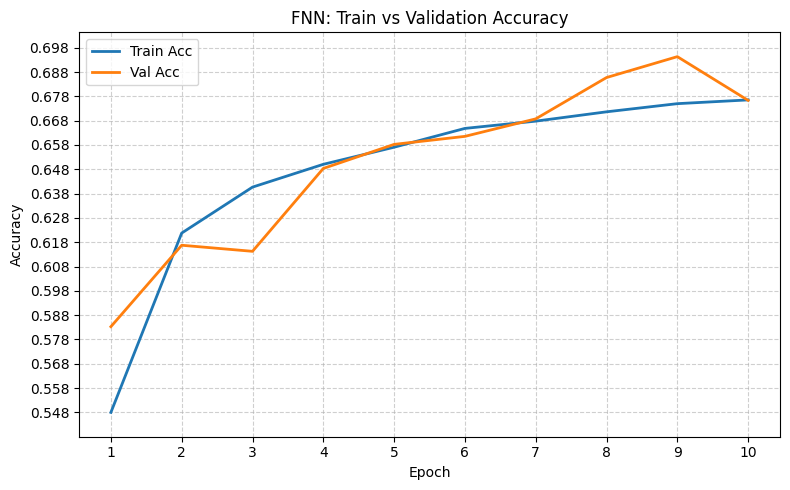

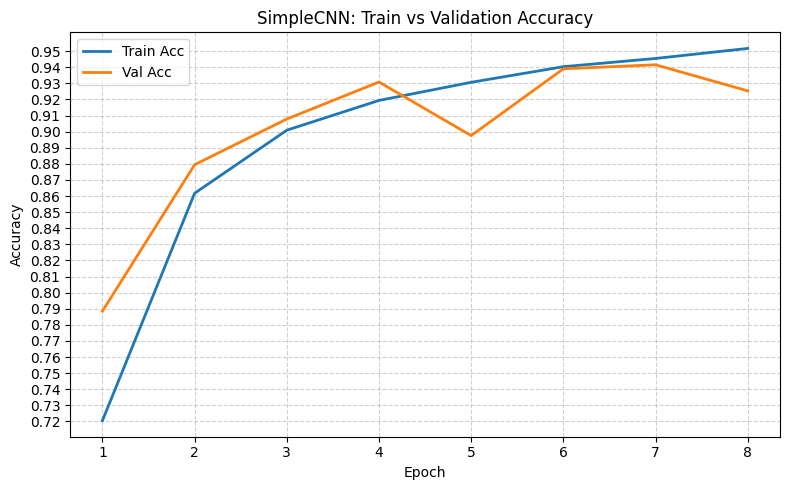

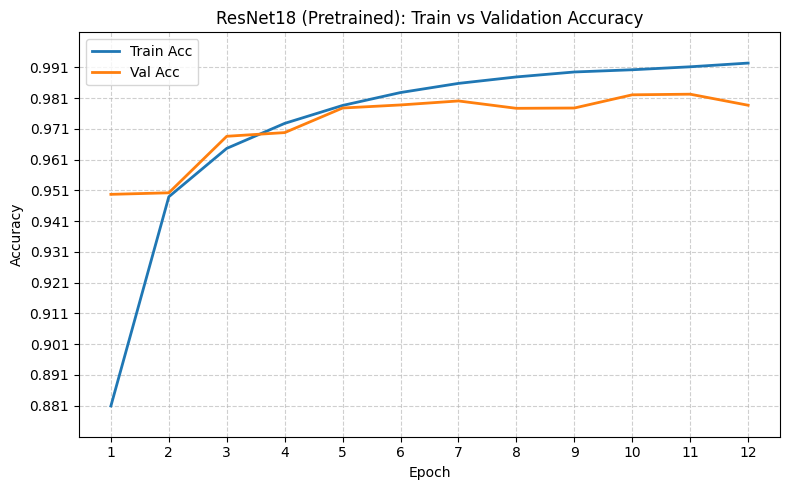

In [30]:
plot_history(fnn_hist, title="FNN")
plot_history(cnn_hist, title="SimpleCNN")
plot_history(resnet_hist, title="ResNet18 (Pretrained)")





=== Final Train/Test Accuracies ===
FNN        - Train: 0.6898, Test: 0.5745
SimpleCNN  - Train: 0.9223, Test: 0.8578
ResNet18   - Train: 0.9918, Test: 0.8989


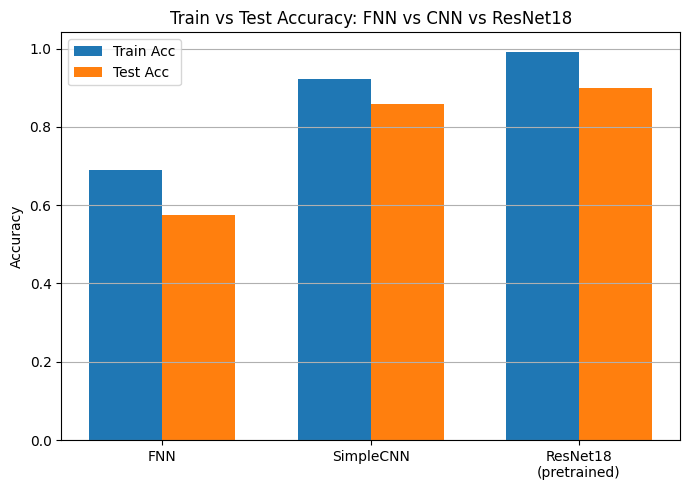

In [32]:
criterion = nn.CrossEntropyLoss()

fnn_train_loss, fnn_train_acc = evaluate(fnn_final, train_loader, criterion, device)
fnn_test_loss,  fnn_test_acc  = evaluate(fnn_final, test_loader,  criterion, device)

cnn_train_loss, cnn_train_acc = evaluate(simple_cnn, train_loader, criterion, device)
cnn_test_loss,  cnn_test_acc  = evaluate(simple_cnn, test_loader,  criterion, device)

resnet_train_loss, resnet_train_acc = evaluate(resnet18_model, train_loader, criterion, device)
resnet_test_loss,  resnet_test_acc  = evaluate(resnet18_model, test_loader,  criterion, device)

print("\n=== Final Train/Test Accuracies ===")
print(f"FNN        - Train: {fnn_train_acc:.4f}, Test: {fnn_test_acc:.4f}")
print(f"SimpleCNN  - Train: {cnn_train_acc:.4f}, Test: {cnn_test_acc:.4f}")
print(f"ResNet18   - Train: {resnet_train_acc:.4f}, Test: {resnet_test_acc:.4f}")

# Bar plot: train vs test accuracy for all three models
models = ["FNN", "SimpleCNN", "ResNet18\n(pretrained)"]
train_accs = [fnn_train_acc, cnn_train_acc, resnet_train_acc]
test_accs  = [fnn_test_acc,  cnn_test_acc,  resnet_test_acc]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, train_accs, width, label="Train Acc")
plt.bar(x + width/2, test_accs,  width, label="Test Acc")
plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy: FNN vs CNN vs ResNet18")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()

In [46]:
print("\n=== Grad-CAM / Grad-CAM++ Visualization for CNN and ResNet18 ===")

# ----- CNN: Grad-CAM + Grad-CAM++ -----
target_layer_cnn = simple_cnn.conv4   # last conv layer of SimpleCNN

gradcam_cnn   = GradCAM(simple_cnn, target_layer_cnn)
gradcampp_cnn = GradCAMPlusPlus(simple_cnn, target_layer_cnn)

save_examples(
    simple_cnn,
    gradcam_cnn,
    gradcampp_cnn,
    test_loader,
    device,
    outdir="xai_outputs_cnn",
)

gradcam_cnn.close()
gradcampp_cnn.close()

# ----- ResNet18: Grad-CAM + Grad-CAM++ -----
target_layer_resnet = resnet18_model.layer4[-1].conv2  # last conv layer of ResNet18

gradcam_resnet   = GradCAM(resnet18_model, target_layer_resnet)
gradcampp_resnet = GradCAMPlusPlus(resnet18_model, target_layer_resnet)

save_examples(
    resnet18_model,
    gradcam_resnet,
    gradcampp_resnet,
    test_loader,
    device,
    outdir="xai_outputs_resnet",
)

gradcam_resnet.close()
gradcampp_resnet.close()



=== Grad-CAM / Grad-CAM++ Visualization for CNN and ResNet18 ===


c:\Users\dashabi\OneDrive\Desktop\ECE1513\.venv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Saved XAI examples to: xai_outputs_cnn
Saved XAI examples to: xai_outputs_resnet


In [ ]:
def save_examples(model, gradcam, gradcampp, test_loader, device, outdir="xai_outputs"):
    """
    Save a few example images with Grad-CAM and Grad-CAM++ overlays.
    """
    os.makedirs(outdir, exist_ok=True)

    images, labels = next(iter(test_loader))
    images = images[:5]
    labels = labels.squeeze()
    if labels.ndim > 1:
        labels = labels.argmax(dim=1)
    labels = labels.long()

    for i in range(len(images)):
        img = images[i]
        cls = int(labels[i].item())

        cam = gradcam.generate(img, cls, device)
        campp = gradcampp.generate(img, cls, device)

        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        # Original (de-normalized)
        axes[0].imshow(denormalize_image(img).permute(1, 2, 0).cpu().numpy())
        axes[0].set_title(f"Original (class {cls})")
        axes[0].axis("off")

        axes[1].imshow(overlay_heatmap(img, cam))
        axes[1].set_title("Grad-CAM")
        axes[1].axis("off")

        axes[2].imshow(overlay_heatmap(img, campp))
        axes[2].set_title("Grad-CAM++")
        axes[2].axis("off")

        plt.tight_layout()
        fig.savefig(os.path.join(outdir, f"example_{i}.png"))
        plt.close(fig)

    print(f"Saved XAI examples to: {outdir}")

In [47]:
def train_model_with_scheduler(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=25,
    lr=1e-4,
    patience=3,
):
    """
    Train model with:
      - ReduceLROnPlateau scheduler
      - Early stopping
    """

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.1,
        patience=2,
        verbose=True
    )

    best_val_acc = 0.0
    best_state = None
    epochs_no_improve = 0

    train_acc_list = []
    val_acc_list = []

    print("\nStarting training with LR scheduler + early stopping...\n")

    for epoch in range(1, num_epochs + 1):
        # ---- Train ----
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # ---- Validate ----
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Save logs
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # ---- Scheduler step ----
        scheduler.step(val_acc)

        # ---- Early Stopping ----
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}!")
            break

    # ---- Restore best model ----
    print(f"\nBest validation accuracy: {best_val_acc:.4f}")
    if best_state:
        model.load_state_dict(best_state)

    return model, train_acc_list, val_acc_list


In [48]:
print("\nTraining ResNet18 (Improved with LR scheduler + Early stopping)...")

resnet18_model = get_resnet18_model(num_classes, use_pretrained=True)

resnet18_model, resnet_train_acc, resnet_val_acc = train_model_with_scheduler(
    resnet18_model,
    train_loader,
    val_loader,
    device,
    num_epochs=25,    # previously 12 → now improved
    lr=1e-4,
    patience=3
)

test_acc_resnet18 = evaluate(resnet18_model, test_loader, criterion, device)
print("ResNet18 Test Accuracy:", test_acc_resnet18)



Training ResNet18 (Improved with LR scheduler + Early stopping)...

Starting training with LR scheduler + early stopping...



c:\Users\dashabi\OneDrive\Desktop\ECE1513\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25 | Train Loss: 0.5808, Train Acc: 0.8829 | Val Loss: 0.4177, Val Acc: 0.9475
Epoch 2/25 | Train Loss: 0.4077, Train Acc: 0.9501 | Val Loss: 0.3716, Val Acc: 0.9656
Epoch 3/25 | Train Loss: 0.3691, Train Acc: 0.9644 | Val Loss: 0.3515, Val Acc: 0.9718
Epoch 4/25 | Train Loss: 0.3472, Train Acc: 0.9745 | Val Loss: 0.3405, Val Acc: 0.9777
Epoch 5/25 | Train Loss: 0.3329, Train Acc: 0.9793 | Val Loss: 0.3332, Val Acc: 0.9787
Epoch 6/25 | Train Loss: 0.3212, Train Acc: 0.9842 | Val Loss: 0.3352, Val Acc: 0.9771
Epoch 7/25 | Train Loss: 0.3167, Train Acc: 0.9859 | Val Loss: 0.3296, Val Acc: 0.9810
Epoch 8/25 | Train Loss: 0.3087, Train Acc: 0.9886 | Val Loss: 0.3239, Val Acc: 0.9829
Epoch 9/25 | Train Loss: 0.3034, Train Acc: 0.9904 | Val Loss: 0.3275, Val Acc: 0.9813
Epoch 10/25 | Train Loss: 0.3008, Train Acc: 0.9914 | Val Loss: 0.3227, Val Acc: 0.9831
Epoch 11/25 | Train Loss: 0.2998, Train Acc: 0.9919 | Val Loss: 0.3226, Val Acc: 0.9831
Epoch 12/25 | Train Loss: 0.2953, Train A